# 第7章 ロジスティクスネットワークの最適設定を行う10本ノック

In [1]:
# 下準備として，データのあるディレクトリに移動しておく
import os

DATA_ROOT_DIR = "./sample/7章/"
os.chdir(DATA_ROOT_DIR)

## ノック61 輸送最適化問題を解いてみよう
pulp, ortoolpyを用いて，最適化問題を解く．

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy  import model_min, addvars, addvals


df_tc = pd.read_csv('trans_cost.csv', index_col="工場")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 初期設定
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

# 数理モデル
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

# 総輸送コスト
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("総輸送コスト :", str(total_cost))

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト : 1296.0


## ノック62 最適輸送ルートをネットワークで確認しよう
計算によって得た最適輸送ルートを可視化する．

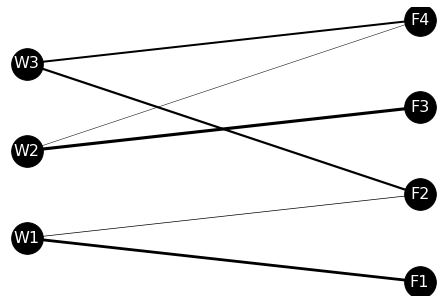

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx


df_tr = df_tr_sol.copy()
df_pos = pd.read_csv("trans_route_pos.csv")

G = nx.Graph()

# 頂点
[G.add_node(node) for node in df_pos.columns]

# 辺
[G.add_edge(node_i, node_j) for node_i in df_tr.index for node_j in df_tr.columns]

# 重み
size = 0.1
edge_weights = [df_tr.loc[warehouse, factory]*size for warehouse in df_tr.index for factory in df_tr.columns]

# 座標
pos = {node:(df_pos[node][0], df_pos[node][1]) for node in df_pos.columns}


nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color="k", font_color="w", width=edge_weights)
plt.show()